<a href="https://colab.research.google.com/github/jiananwu72/Defect-Detection/blob/main/LFODemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pyNSID sidpy SciFiReaders nanonispy gwyfile pyTEMlib wget ipympl importlib wget
!pip install numpy==1.26.4

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

import sys
sys.path.insert(0, '../../')
sys.path.insert(0, '../../../sidpy')
import sidpy

%load_ext autoreload
%autoreload 2

import pyTEMlib
import pyTEMlib.file_tools      # File input/ output library
import pyTEMlib.image_tools

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
Symmetry functions of spglib enabled
Qt dialogs are not available
SimpleITK not installed; Registration Functions for Image Stacks not available
install with: conda install -c simpleitk simpleitk 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


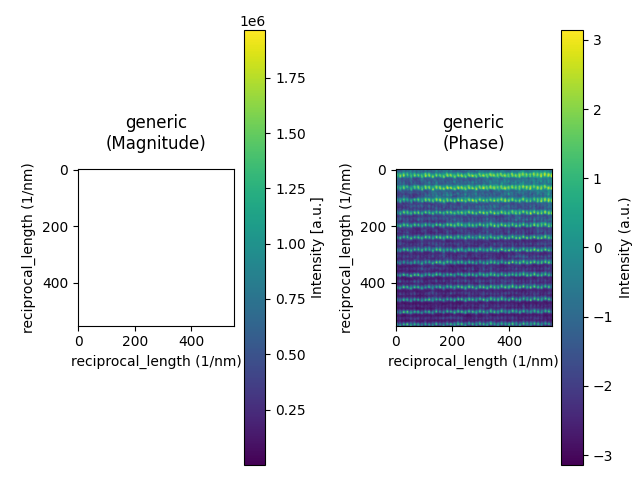

In [42]:
from PIL import Image
import matplotlib.pyplot as plt

# Change for each pictures
img_path = '/content/drive/MyDrive/Data/LFO/Picture2.png'
img = Image.open(img_path).convert('L')
image = np.array(img).astype(np.float32)
image = image

plt.imshow(image)
plt.show()

In [43]:
dataset = sidpy.Dataset.from_array(image)
dataset.quantity = 'Intensity'
dataset.title = 'TEM image'
dataset.units = 'a.u.'
dataset.data_type = sidpy.DataType.IMAGE
dataset.modality = 'Experimental'
dataset.set_dimension(0, sidpy.Dimension(np.arange(dataset.shape[0]),
                                          name='x', units='nm', quantity='Length',
                                          dimension_type='spatial'))
dataset.set_dimension(1, sidpy.Dimension(np.arange(dataset.shape[1]),
                                          name='y', units='nm', quantity='Length',
                                          dimension_type='spatial'))

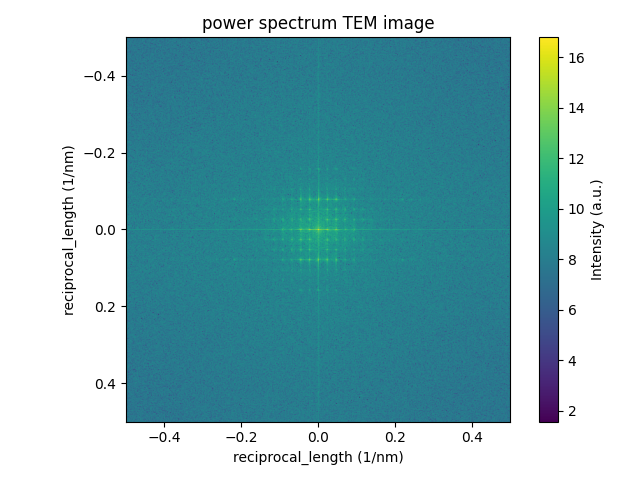

In [57]:
smoothing = 0
import scipy.ndimage as ndimage
fft_transform = pyTEMlib.image_tools.fourier_transform(dataset)
fft_mag = np.abs(fft_transform)
fft_mag2 = ndimage.gaussian_filter(fft_mag, sigma=(smoothing, smoothing), order=0)

power_spectrum = fft_transform.like_data(np.log(1.+fft_mag2))

# prepare mask
x, y = np.meshgrid(power_spectrum.v.values, power_spectrum.u.values)
mask = np.zeros(power_spectrum.shape)

mask_spot = x ** 2 + y ** 2 > 0.5 ** 2
mask = mask + mask_spot
mask_spot = x ** 2 + y ** 2 < 11 ** 2
mask = mask + mask_spot

mask[np.where(mask == 1)] = 0  # just in case of overlapping disks

minimum_intensity = np.array(power_spectrum)[np.where(mask == 2)].min() * 0.95
maximum_intensity = np.array(power_spectrum)[np.where(mask == 2)].max() * 1.05
power_spectrum.metadata = {'fft': {'smoothing': smoothing,
                                'minimum_intensity': minimum_intensity, 'maximum_intensity': maximum_intensity}}
power_spectrum.title = 'power spectrum ' + power_spectrum.source
view = power_spectrum.plot()

In [1]:
# ------Input----------
spot_threshold=0.01
# ---------------------

spots, _ = pyTEMlib.image_tools.diffractogram_spots(power_spectrum, spot_threshold=spot_threshold)
spots = spots[np.linalg.norm(spots[:,:2],axis=1)<7,:]
spots = spots[np.linalg.norm(spots[:,:2],axis=1)>0.5,:]
power_spectrum.plot()

plt.gca().scatter(spots[:,0],spots[:,1], color='red', alpha=0.4);

NameError: name 'pyTEMlib' is not defined